## This is a notebook to walk through the carbon P90 analysis

The notebook will look at the data, analyse the accuracy of the data and then perform a P90 analysis on it

In [5]:
'''
Let us first install the necessary libraries:
(you may have to install these libraries in your virtual environment from the command line)
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta

# setting to make the plots nicer
import seaborn as sns
sns.set(style="whitegrid")

### Import the Data

Let us now import the data and have a quick look at it

In [3]:
# import data
solar = pd.read_csv('Data/1_month_solar.csv')

# rename columns
solar.rename(columns={'Datetime':'datetime'}, inplace=True)
solar.rename(columns={'Global Horizontal DH3 (W/m^2)':'power'}, inplace=True)

# convert to datetime
solar['datetime'] = pd.to_datetime(solar['datetime'])

# set datetime as index
solar.set_index('datetime', inplace=True)

# remove any negative values
solar['power'].clip(lower=0, inplace=True)

# inspect the data
solar

,power
datetime,
2017-06-01 05:00:00,0.47216
2017-06-01 05:00:01,0.47216
2017-06-01 05:00:02,0.47216
2017-06-01 05:00:03,0.47216
2017-06-01 05:00:04,0.47216
...,...
2017-06-30 19:59:55,0.00000
2017-06-30 19:59:56,0.00000
2017-06-30 19:59:57,0.00000


## Visualise the data

now we know that the data starts at 2017-06-01 05:00:00 and ends at 2017-06-30 19:59:59

Lets look at one days worth of solar generation from the data

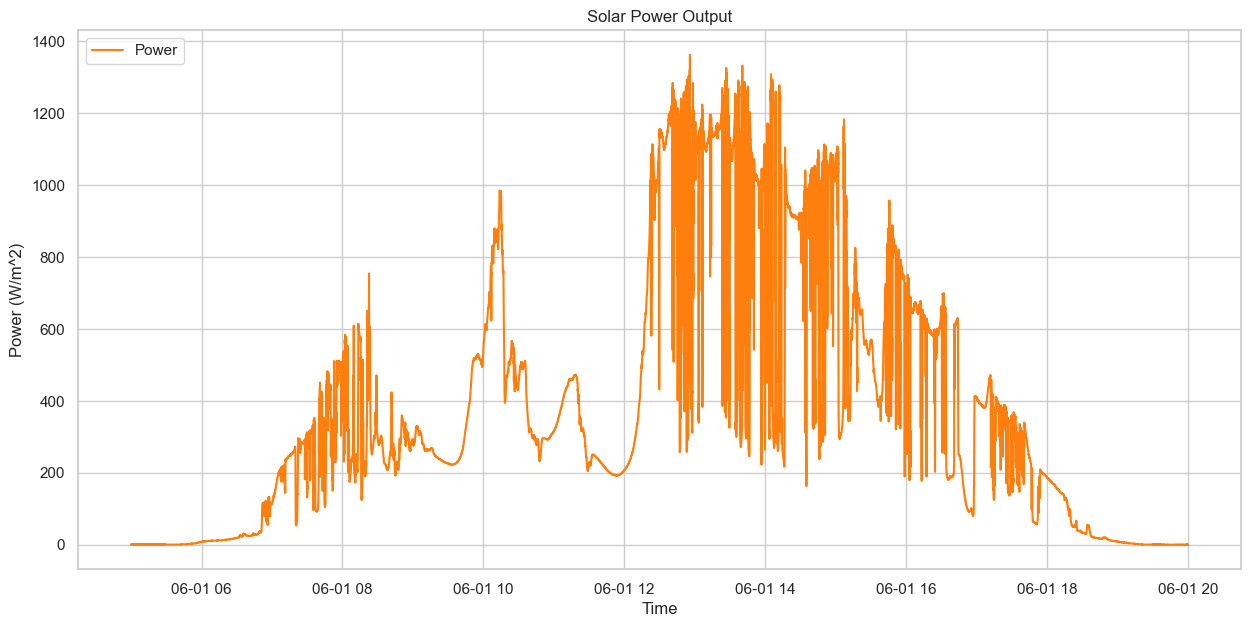

In [7]:
# selsect timeframe to look over
start_dt = datetime(year=2017, month=6, day=1)
end_dt = datetime(year=2017, month=6, day=2)
solar_slice = solar.loc[start_dt:end_dt]

# plot the data
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(solar_slice.index, solar_slice['power'], color='tab:orange')
ax.set_xlabel('Time')
ax.set_ylabel('Power (W/m^2)')
ax.set_title('Solar Power Output')
ax.legend(['Power'], loc='upper left')
